In [5]:
# ============== 线性回归的从零开始实现 ====================
"""
1.先构建数据集（训练集）
2.随机选取小批量样本
3.构建线性回归模型
4.构建损失函数
5.初始化参数（w b）
6.构建小批量随机梯度下降模型，训练参数 w b
"""

'\n1.先构建数据集（训练集）\n2.随机选取小批量样本\n3.构建线性回归模型\n4.构建损失函数\n5.初始化参数（w b）\n6.构建小批量随机梯度下降模型，训练参数 w b\n'

In [13]:
# 让 matplotlib 绘制的图像直接显示在单元格下方，而不是弹出新窗口
%matplotlib inline  

# Python 标准库，用于生成随机数
import random

# 导入 PyTorch 深度学习框架;提供张量运算、自动求导、神经网络模块等
import torch

# 导入 《动手学深度学习》（D2L） 的 PyTorch 版本工具函数
# D2L 是李沐老师的开源教材，提供了很多实用函数
from d2l import torch as d2l

In [14]:
# 根据带有噪声的线性模型构造一个人造数据集
# 使用线性模型参数 w = [2, -3.4]T , b = 4.2和噪声项生成数据集及其标签
# y = Xw + b + ε

# ===========生成一个人造数据集，后续根据这个数据集训练 w , b ============
def synthetic_data(w, b, num_examples):
    """ 生成 y = Xw + b + ε """
    # 生成特征矩阵 X （符合标准正态分布，正态分布=高斯分布）
    X = torch.normal(0, 1, (num_examples, len(w)))

    # 计算 y = Xw + b,用到了广播机制（Xw是向量，b是标量）
    y = torch.matmul(X, w) + b

    # 添加高斯噪声，均值0，标准差0.01，方差0.0001，形状与 y 一致
    y += torch.normal(0, 0.01, y.shape)

    # y.reshape((-1,1)):将 y 转为列向量
    return X, y.reshape((-1, 1))


true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [26]:
# features中的每一行都包含一个二维数据样本
# labels中的每一行都包含一维标签值（一个标量）
print('features[0] = ', features[0], '\n')
print('labels[0] = ',labels[0], '\n')

features[0] =  tensor([ 1.0902, -0.0666]) 

labels[0] =  tensor([6.5905]) 



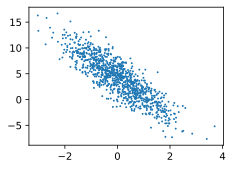

In [27]:
# 设置 matplotlib 图像的默认尺寸
d2l.set_figsize()

"""
features[:,1] 选择第二列
.detach() 从计算图中分离，如果features 有 requires_grad=True，需要先分离，防止绘图操作影响梯度计算
.numpy() 转换为NumPy数组，因为matplotlib需要NumPy数组作为输入
d2l.plt.scatter(x, y, s=1)  x:x轴数据,y:y轴数据，s=1:点的大小（像素）
分号; 的作用是抑制最后一条语句的输出，因为jupyter notebook单元格最后一行会自动显示输出
"""
d2l.plt.scatter(features[:,1].detach().numpy(),
                labels.detach().numpy(), 1);

In [15]:
"""
《生成小批量数据的迭代器函数》
输入：
batch_size：批量大小
features：特征矩阵，形状 (num_examples, num_features)
labels：标签向量，形状 (num_examples, 1)
输出：个数为batch_size的样本集（包含特征矩阵、标签向量）
"""
def data_iter(batch_size, features, labels):
    # 获取样本总数
    num_examples = len(features)

    # 创建索引列表 [0, 1, 2, ..., num_examples-1]
    indices = list(range(num_examples))

    # 随机打乱索引（实现数据随机化）
    random.shuffle(indices)

    #按批次生成数据  i = 0, batch_size, 2*batch_size, ...
    for i in range(0, num_examples, batch_size):
        # 获取当前批次的索引 min(i + batch_size, num_examples)确保不越界
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size, num_examples)]
        )
        
        # 生成当前批次的数据
        # yield 是 Python 中创建生成器的关键字，它让函数可以暂停执行并返回值，下次调用时从暂停处继续执行
        yield features[batch_indices], labels[batch_indices]


batch_size = 10

# 使用生成器迭代数据，并且只查看第一个批次的数据
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y) # 自动解包：X = 第一个元素特征矩阵，y = 第二个元素标签向量
    break

"""
# 不解包：直接获取元组
for batch in data_iter(batch_size, features, labels):
    X = batch[0]  # 第一个元素是特征
    y = batch[1]  # 第二个元素是标签
    print(X, y)
    break
"""

tensor([[-0.1527,  1.7708],
        [-1.1399,  1.3645],
        [ 0.7462,  0.5476],
        [ 1.6790, -0.3903],
        [ 0.0077, -0.5090],
        [-0.3043,  0.2690],
        [ 0.1632,  0.3358],
        [ 0.1728, -0.0897],
        [ 1.2394,  1.6619],
        [ 1.2382, -0.8439]]) 
 tensor([[-2.1141],
        [-2.7094],
        [ 3.8109],
        [ 8.8895],
        [ 5.9697],
        [ 2.6700],
        [ 3.3816],
        [ 4.8544],
        [ 1.0214],
        [ 9.5608]])


'\n# 不解包：直接获取元组\nfor batch in data_iter(batch_size, features, labels):\n    X = batch[0]  # 第一个元素是特征\n    y = batch[1]  # 第二个元素是标签\n    print(X, y)\n    break\n'

In [16]:
# 定义初始化模型参数
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [17]:
# 定义线性回归模型
def linreg(X, w, b):
    return torch.matmul(X, w) + b

In [18]:
# 定义损失函数
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

In [19]:
# 定义优化算法————小批量随机梯度下降
"""
params 参数列表（包含向量w 标量b）
lr 学习率（写成 lr = learning rate也可以）
"""
def sgd(params, lr, batch_size):
    with torch.no_grad():  # 禁用计算梯度，更新参数的时候不参与梯度计算
        for param in params:
            param -= lr * param.grad / batch_size# 梯度下降
            param.grad.zero_()

In [22]:
# 训练过程
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        # 前向传播计算损失
        l = loss(net(X, w, b), y)

        # 梯度清零
        if w.grad is not None:
            w.grad.zero_()
        #if b.grad is not None:
            #b.grad_zero_()

        # 反向传播
        l.sum().backward()

        # 小批量梯度下降更新参数
        sgd([w,b], lr, batch_size)

    # 每个epoch结束后评估训练损失
    with torch.no_grad():
        train_1 = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_1.mean()):f}')

epoch 1, loss 0.000121
epoch 2, loss 0.000053
epoch 3, loss 0.000053
